#                The Movie Database API and Oscar Movies (1934-2015) 
#                        Data Analysis and 2019 Oscar Prediction

##                                              Part 1.   Data Analysis

In [1]:
%matplotlib inline

import seaborn as sns
import scipy
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve,auc
#from sklearn.cross_validation import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

from sklearn.feature_selection import RFE

import random

from scipy.stats import ttest_ind

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter # to format currency on charts axis

from wordcloud import WordCloud

In [3]:
import pandas as pd
import numpy as np

import requests 
from pprint import pprint




## Import all movie data from tmdb 5000 data set and Oscar Winning Data

In [4]:
tmdb_orig_db = pd.read_csv('./DataSources/tmdb_5000_movies.csv')

oscar_movie_db = pd.read_csv('./DataSources/Oscars1934-2015.csv')
oscar_movie_db.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1934,7,Actor,1,Clark Gable,It Happened One Night
1,1934,7,Actor,0,Frank Morgan,The Affairs of Cellini
2,1934,7,Actor,0,William Powell,The Thin Man
3,1934,7,Actress,1,Claudette Colbert,It Happened One Night
4,1934,7,Actress,0,Bette Davis,Of Human Bondage


In [5]:
oscar_movie_db.head()

,Year,Ceremony,Award,Winner,Name,Film
0,1934,7,Actor,1,Clark Gable,It Happened One Night
1,1934,7,Actor,0,Frank Morgan,The Affairs of Cellini
2,1934,7,Actor,0,William Powell,The Thin Man
3,1934,7,Actress,1,Claudette Colbert,It Happened One Night
4,1934,7,Actress,0,Bette Davis,Of Human Bondage


In [6]:
tmdb_orig_db.count()

budget                  4803
genres                  4803
homepage                1712
id                      4803
keywords                4803
original_language       4803
original_title          4803
overview                4800
popularity              4803
production_companies    4803
production_countries    4803
release_date            4802
revenue                 4803
runtime                 4801
spoken_languages        4803
status                  4803
tagline                 3959
title                   4803
vote_average            4803
vote_count              4803
dtype: int64

In [7]:
columns = ['id','title','budget','revenue','vote_average','runtime','vote_count','popularity','release_date','keywords','genres']


tmdb_movie_info_df = tmdb_orig_db[columns]



In [8]:
tmdb_movie_info_df = tmdb_movie_info_df.dropna()

In [9]:
tmdb_movie_info_df['release_month'] = pd.DatetimeIndex(tmdb_movie_info_df['release_date']).month

tmdb_movie_info_df.release_month = tmdb_movie_info_df.release_month.astype(int)
#all_movies_info_df.head()



In [10]:
tmdb_movie_info_df = tmdb_movie_info_df.drop(columns = ['release_date'])
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month
0,19995,Avatar,237000000,2787965087,7.2,162.0,11800,150.437577,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",12
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",5
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",10
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",3


In [11]:
import json
tmdb_movie_info_df['keywords']=tmdb_movie_info_df['keywords'].apply(json.loads)
tmdb_movie_info_df['genres']=tmdb_movie_info_df['genres'].apply(json.loads)

### Analysis TMDB movie Keywords and Genres

In [12]:
def get_names(keywords):
    return '|'.join([x['name'] for x in keywords]) 

tmdb_movie_info_df['genres'] = tmdb_movie_info_df['genres'].apply(get_names)
tmdb_movie_info_df['keywords'] = tmdb_movie_info_df['keywords'].apply(get_names)

In [13]:
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month
0,19995,Avatar,237000000,2787965087,7.2,162.0,11800,150.437577,culture clash|future|space war|space colony|so...,Action|Adventure|Fantasy|Science Fiction,12
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,ocean|drug abuse|exotic island|east india trad...,Adventure|Fantasy|Action,5
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,spy|based on novel|secret agent|sequel|mi6|bri...,Action|Adventure|Crime,10
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,dc comics|crime fighter|terrorist|secret ident...,Action|Crime|Drama|Thriller,7
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,based on novel|mars|medallion|space travel|pri...,Action|Adventure|Science Fiction,3


In [14]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: 
        keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [15]:
def keys_set(df,col_name):
    keys = set()
    for keyword in df[col_name].str.split('|').values:
        if isinstance(keyword, float): continue  # only happen if liste_keywords = NaN
        keys = keys.union(keyword)
    keys.remove('')
    return keys

keywords_set = keys_set(tmdb_movie_info_df,'keywords')
keyword_occurences, dum = count_word(tmdb_movie_info_df, 'keywords', keywords_set)
keyword_occurences[:5]



[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

In [16]:
genres_set = keys_set(tmdb_movie_info_df,'genres')

In [17]:
genres_set

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'}

In [18]:
#genre_labels = set()
#for s in tmdb_movie_info_df['genres'].str.split('|').values:
#    genre_labels = genre_labels.union(set(s))
 

genres_occurences,dum = count_word(tmdb_movie_info_df, 'genres', genres_set)
genres_occurences[:5]

[['Drama', 2296],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [19]:
genre_sets = keys_set(tmdb_movie_info_df,'genres')
genres_occurences = count_word(tmdb_movie_info_df, 'genres', genre_sets)

In [20]:
genres_occurences

([['Drama', 2296],
  ['Comedy', 1722],
  ['Thriller', 1274],
  ['Action', 1154],
  ['Romance', 894],
  ['Adventure', 790],
  ['Crime', 696],
  ['Science Fiction', 535],
  ['Horror', 519],
  ['Family', 513],
  ['Fantasy', 424],
  ['Mystery', 348],
  ['Animation', 234],
  ['History', 197],
  ['Music', 185],
  ['War', 144],
  ['Documentary', 109],
  ['Western', 82],
  ['Foreign', 34],
  ['TV Movie', 8]],
 {'Animation': 234,
  'War': 144,
  'Family': 513,
  'Documentary': 109,
  'Fantasy': 424,
  'Crime': 696,
  'Drama': 2296,
  'Adventure': 790,
  'Western': 82,
  'Horror': 519,
  'History': 197,
  'Science Fiction': 535,
  'Thriller': 1274,
  'TV Movie': 8,
  'Action': 1154,
  'Romance': 894,
  'Comedy': 1722,
  'Foreign': 34,
  'Mystery': 348,
  'Music': 185})

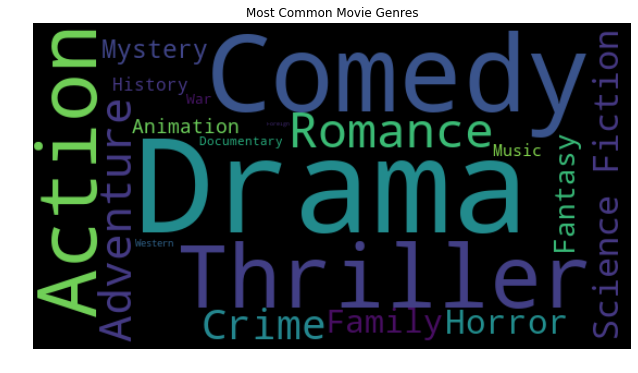

In [21]:
words = dict()
trunc_occurences = genres_occurences[0]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Most Common Movie Genres')
plt.show()

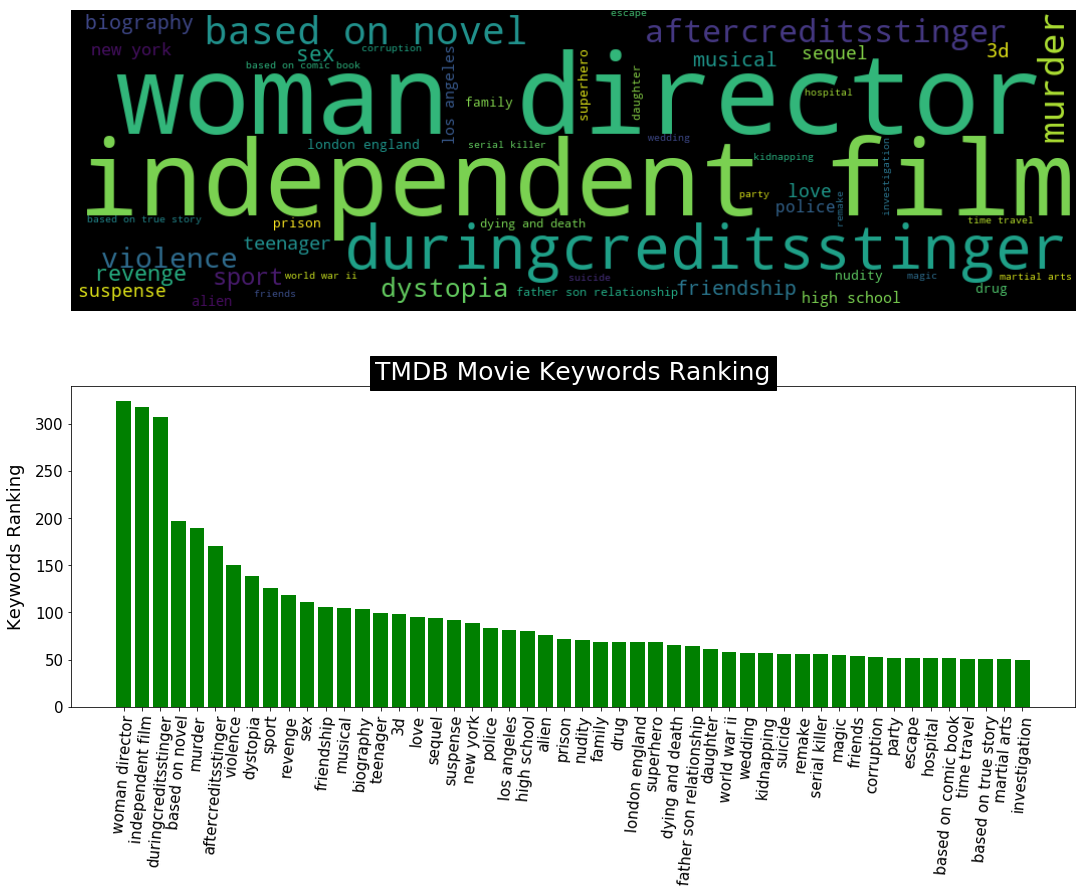

In [22]:
# UPPER PANEL: WORDCLOUD
fig = plt.figure(1, figsize=(18,13))
ax1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# I define the dictionary used to produce the wordcloud
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
wordcloud = WordCloud(width=1000,height=300, background_color='black', 
                      max_words=1628,relative_scaling=1,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation="bilinear")
ax1.axis('off')
#_____________________________________________
# LOWER PANEL: HISTOGRAMS
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Keywords Ranking", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("TMDB Movie Keywords Ranking",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
plt.show()

## 1934 - 2015 Oscar Winning Movies Data Analysis

In [23]:

best_pictures_df = oscar_movie_db[((oscar_movie_db['Award']== 'Best Picture')|(oscar_movie_db['Award']== 'Best Motion Picture'))&(oscar_movie_db['Winner'] == 1)]
best_pictures_df = best_pictures_df.rename(columns = {'Name' : 'title','Film' : 'production'})
best_pictures_df.head()

,Year,Ceremony,Award,Winner,title,production
1488,1944,17,Best Motion Picture,1,Going My Way,Paramount
1646,1945,18,Best Motion Picture,1,The Lost Weekend,Paramount
1762,1946,19,Best Motion Picture,1,The Best Years of Our Lives,Samuel Goldwyn Productions
1869,1947,20,Best Motion Picture,1,Gentleman's Agreement,20th Century-Fox
1978,1948,21,Best Motion Picture,1,Hamlet,J. Arthur Rank-Two Cities Films


In [24]:
winner_film_name = list(best_pictures_df['title'])

In [25]:
best_pictures_df.head()

,Year,Ceremony,Award,Winner,title,production
1488,1944,17,Best Motion Picture,1,Going My Way,Paramount
1646,1945,18,Best Motion Picture,1,The Lost Weekend,Paramount
1762,1946,19,Best Motion Picture,1,The Best Years of Our Lives,Samuel Goldwyn Productions
1869,1947,20,Best Motion Picture,1,Gentleman's Agreement,20th Century-Fox
1978,1948,21,Best Motion Picture,1,Hamlet,J. Arthur Rank-Two Cities Films


In [28]:
len(best_pictures_df)

73

## Oscar Best Picture/Motion Picture Data Query via TMDB api

In [26]:
# use api.tmdb.org due to problem of 'query limit is 40'
base_url ='https://api.tmdb.org/3/search/movie?'
api_key = 'api_key=d5b4e5d5145be601d4640d76efd791e3'
query = '&query='
query_base_url = base_url + api_key + query

# best_pic_info: get the movie summary information 
best_pic_info = []

for i in range(len(winner_film_name)): 
    release_year = best_pictures_df.loc[best_pictures_df['title'] == winner_film_name[i],'Year'].item()
    movie_info = query_base_url + winner_film_name[i] + '&year=' + str(release_year)
    response=requests.get(movie_info).json()
    best_pic_info.append(response['results'])

In [27]:
best_pic_info

[[{'vote_count': 51,
   'id': 17661,
   'video': False,
   'vote_average': 7.1,
   'title': 'Going My Way',
   'popularity': 3.492,
   'poster_path': '/2VhlXVPqyU2XXjCss83oXtHgage.jpg',
   'original_language': 'en',
   'original_title': 'Going My Way',
   'genre_ids': [18, 35, 10402],
   'backdrop_path': '/jiGn1FXSQVfN2nhix0tQtmoGWcF.jpg',
   'adult': False,
   'overview': "Youthful Father Chuck O'Malley led a colorful life of sports, song, and romance before joining the Roman Catholic clergy. After being appointed to a run-down New York parish , O'Malley's worldly knowledge helps him connect with a gang of boys looking for direction, eventually winning over the aging, conventional Parish priest.",
   'release_date': '1944-05-15'}],
 [{'vote_count': 184,
   'id': 28580,
   'video': False,
   'vote_average': 7.6,
   'title': 'The Lost Weekend',
   'popularity': 5.335,
   'poster_path': '/5fZWKQREZ3QVNjBKMLa7NmqufnE.jpg',
   'original_language': 'en',
   'original_title': 'The Lost Weeke

In [29]:
base_url1 = 'https://api.tmdb.org/3/movie/'

language = '&language=en-US'
keyword = '/keywords?'
Winner_Details= []
keyword_details = []
tmdb_id_list = []
#keywords: https://api.themoviedb.org/3/movie/23383/keywords?api_key=d5b4e5d5145be601d4640d76efd791e3

for i in range(len(best_pic_info)):
    tmdb_id = str(best_pic_info[i][0]['id'])
    tmdb_id_list.append(best_pic_info[i][0]['id'])
    detail_query_link = base_url1 + tmdb_id + '?' + api_key + language
    keywords_query_link = base_url1 + tmdb_id + keyword + api_key
    response = requests.get(detail_query_link).json()
    keywords_response = requests.get(keywords_query_link).json()
    Winner_Details.append(response)
    keyword_details.append(keywords_response)

In [30]:
Winner_Details

[{'adult': False,
  'backdrop_path': '/jiGn1FXSQVfN2nhix0tQtmoGWcF.jpg',
  'belongs_to_collection': {'id': 556928,
   'name': "Father O'Malley Collection",
   'poster_path': None,
   'backdrop_path': None},
  'budget': 0,
  'genres': [{'id': 18, 'name': 'Drama'},
   {'id': 35, 'name': 'Comedy'},
   {'id': 10402, 'name': 'Music'}],
  'homepage': None,
  'id': 17661,
  'imdb_id': 'tt0036872',
  'original_language': 'en',
  'original_title': 'Going My Way',
  'overview': "Youthful Father Chuck O'Malley led a colorful life of sports, song, and romance before joining the Roman Catholic clergy. After being appointed to a run-down New York parish , O'Malley's worldly knowledge helps him connect with a gang of boys looking for direction, eventually winning over the aging, conventional Parish priest.",
  'popularity': 2.555,
  'poster_path': '/2VhlXVPqyU2XXjCss83oXtHgage.jpg',
  'production_companies': [{'id': 4,
    'logo_path': '/fycMZt242LVjagMByZOLUGbCvv3.png',
    'name': 'Paramount',
    

In [31]:
keyword_details

[{'id': 17661, 'keywords': [{'id': 10093, 'name': 'priest'}]},
 {'id': 28580,
  'keywords': [{'id': 1333, 'name': 'desperation'},
   {'id': 2340, 'name': 'paranoia'},
   {'id': 2677, 'name': 'weekend'},
   {'id': 3458, 'name': 'bartender'},
   {'id': 5301, 'name': 'brother'},
   {'id': 6782, 'name': 'addiction'},
   {'id': 7464, 'name': 'alcoholism'},
   {'id': 11258, 'name': 'suicidal'},
   {'id': 13028, 'name': 'writer'},
   {'id': 33457, 'name': 'alcoholic'},
   {'id': 156318, 'name': 'bats'},
   {'id': 171567, 'name': 'low self esteem'},
   {'id': 187844, 'name': 'flashback'},
   {'id': 193305, 'name': 'dishonesty'},
   {'id': 195402, 'name': 'film noir'},
   {'id': 215015, 'name': 'hopelessness'},
   {'id': 220488, 'name': 'delirium tremens'},
   {'id': 230479, 'name': 'lies'},
   {'id': 234091, 'name': 'evasion'},
   {'id': 239226, 'name': 'devoted girlfriend'}]},
 {'id': 887,
  'keywords': [{'id': 279, 'name': 'usa'},
   {'id': 447, 'name': 'post traumatic stress  disorder'},
  

In [32]:
winning_keywords = []
keywords_list = []

for i in range(len(keyword_details)):
    for j in range(len(keyword_details[i]['keywords'])):
        winning_keywords.append(keyword_details[i]['keywords'][j]['name'])
    keywords_list.append(keyword_details[i]['keywords'])

   
    

In [33]:
winning_keywords

['priest',
 'desperation',
 'paranoia',
 'weekend',
 'bartender',
 'brother',
 'addiction',
 'alcoholism',
 'suicidal',
 'writer',
 'alcoholic',
 'bats',
 'low self esteem',
 'flashback',
 'dishonesty',
 'film noir',
 'hopelessness',
 'delirium tremens',
 'lies',
 'evasion',
 'devoted girlfriend',
 'usa',
 'post traumatic stress  disorder',
 'war veteran',
 'world war ii',
 'rehabilitation',
 'bodily disabled person',
 'based on novel or book',
 'magazine',
 'anti semitism',
 'writer',
 'soldier',
 'new york city',
 'widower',
 'racial prejudice',
 'gentile',
 'father and son',
 'shakespeare',
 'father murder',
 'based on play or musical',
 'southern usa',
 'based on novel or book',
 'newspaper',
 'governor',
 'politics',
 'politician',
 'rise and fall',
 'reporter',
 'political assassination',
 'corrupt politician',
 'hick',
 'jealousy',
 'obsession',
 'manipulation',
 'fan',
 'engagement',
 'celebrity',
 'party',
 'playwright',
 'hollywood',
 'black and white',
 'director',
 'relatio

Text(0.5, 1.0, 'Oscar Best Picture Movie Keywords')

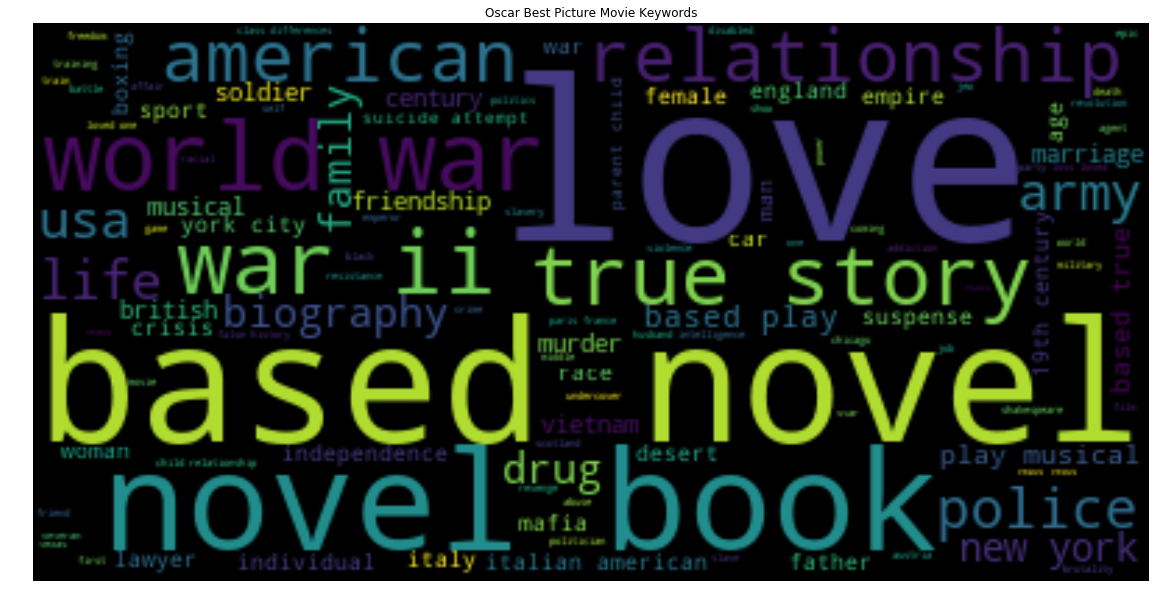

In [34]:


wc = WordCloud(background_color="white", max_words=1000,contour_width=3, contour_color='steelblue')



text = ' '.join(winning_keywords)
# Generate a word cloud image
#wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_words=1000).generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Oscar Best Picture Movie Keywords')


### Build Movie Features Data set

In [35]:
revenue_list = []
budget_list = []
runtime_list = []
vote_average_list = []
vote_count_list =[]
pop_list = []
genre_list =[]
release_date_list = []


for i in range(len(Winner_Details)):
    revenue_list.append(Winner_Details[i]['revenue'])
    budget_list.append(Winner_Details[i]['budget'])
    runtime_list.append(Winner_Details[i]['runtime'])
    vote_average_list.append(Winner_Details[i]['vote_average'])
    vote_count_list.append(Winner_Details[i]['vote_count'])
    pop_list.append(Winner_Details[i]['popularity'])
    genre_list.append(Winner_Details[i]['genres'])
    release_date_list.append(Winner_Details[i]['release_date'])
    


In [36]:
release_month_list = []
for i in range(len(release_date_list)):
    release_month = release_date_list[i].split('-')
    release_month_list.append(release_month[1])
        

In [37]:
best_pictures_df['id'] = pd.Series(tmdb_id_list).values
best_pictures_df['revenue'] = pd.Series(revenue_list).values
best_pictures_df['budget'] =  pd.Series(budget_list).values
best_pictures_df['runtime'] = pd.Series(runtime_list).values
best_pictures_df['vote_average'] = pd.Series(vote_average_list).values
best_pictures_df['vote_count'] = pd.Series(vote_count_list).values
best_pictures_df['popularity'] = pd.Series(pop_list).values
best_pictures_df['genres'] = pd.Series(genre_list).values
best_pictures_df['release_month'] = pd.Series(release_month_list).values
best_pictures_df['keywords'] = pd.Series(keywords_list).values

In [38]:
best_pictures_df.dtypes

Year               int64
Ceremony           int64
Award             object
Winner             int64
title             object
production        object
id                 int64
revenue            int64
budget             int64
runtime            int64
vote_average     float64
vote_count         int64
popularity       float64
genres            object
release_month     object
keywords          object
dtype: object

# Oscar Best Picture/Motion picture Movie Analysis

## 1. Genre and Release Month Analysis

In [39]:
genre_list = list(best_pictures_df['genres'])

winning_genre = []
for i in range(len(genre_list)):
    for j in range(len(genre_list[i])):
        winning_genre.append(genre_list[i][j]['name'])
    

winning_genre_df = pd.DataFrame({'genres':winning_genre})
winning_genre_counts = winning_genre_df['genres'].value_counts()

winning_genre_counts = winning_genre_counts.rename_axis('genres').reset_index(name = 'counts')

In [144]:
genre_list

[[{'id': 18, 'name': 'Drama'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 10402, 'name': 'Music'}],
 [{'id': 18, 'name': 'Drama'}],
 [{'id': 18, 'name': 'Drama'},
  {'id': 36, 'name': 'History'},
  {'id': 10749, 'name': 'Romance'}],
 [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}],
 [{'id': 18, 'name': 'Drama'}],
 [{'id': 18, 'name': 'Drama'}],
 [{'id': 18, 'name': 'Drama'}],
 [{'id': 18, 'name': 'Drama'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 10402, 'name': 'Music'},
  {'id': 10749, 'name': 'Romance'}],
 [{'id': 28, 'name': 'Action'},
  {'id': 18, 'name': 'Drama'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 35, 'name': 'Comedy'}],
 [{'id': 18, 'name': 'Drama'},
  {'id': 10749, 'name': 'Romance'},
  {'id': 10752, 'name': 'War'}],
 [{'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}],
 [{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}],
 [{'id': 12, 'name': 'Adventure'},
  {'id': 35, 'name': 'Comedy'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14,

In [40]:
winning_genre_counts

,genres,counts
0,Drama,65
1,Romance,22
2,Comedy,17
3,History,17
4,War,11
5,Crime,11
6,Thriller,9
7,Music,8
8,Adventure,7
9,Action,6


In [41]:
winning_month_count = best_pictures_df.groupby('release_month')['Award'].count()

In [42]:
winning_month_count_df = winning_month_count.to_frame()

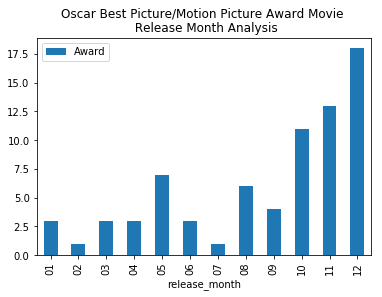

In [43]:
# Only focus on the Best Picture Category
winning_month_count_df.plot(kind = 'bar',title = 'Oscar Best Picture/Motion Picture Award Movie \n Release Month Analysis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

<Figure size 1440x1440 with 0 Axes>

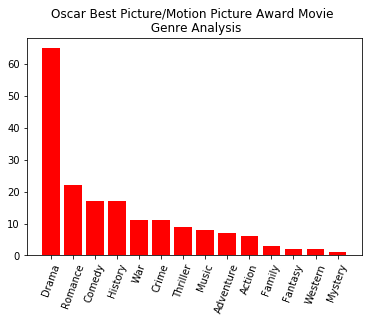

In [44]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()


plt.bar(winning_genre_counts['genres'],winning_genre_counts['counts'],color = 'red')
plt.title('Oscar Best Picture/Motion Picture Award Movie \n Genre Analysis')
plt.xticks(rotation=70)


## 2. Oscar Best Picture/Motion Films Revenues/Budgets Analysis

<Figure size 1440x1440 with 0 Axes>

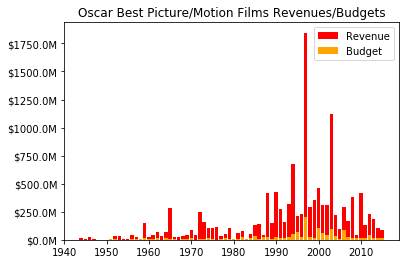

In [45]:


def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)

plt.figure(figsize=(20,20))
fig, ax = plt.subplots()


p1 = plt.bar(best_pictures_df['Year'],best_pictures_df['revenue'],color = 'red')

p2 = plt.bar(best_pictures_df['Year'],best_pictures_df['budget'], color = 'orange')

ax.yaxis.set_major_formatter(formatter)
plt.title('Oscar Best Picture/Motion Films Revenues/Budgets')
plt.legend((p1[0],p2[0]),('Revenue','Budget'))
plt.show()


# 3. Oscar Best Picture/Motion Films Vote/Popularity Analysis

<Figure size 1440x14400 with 0 Axes>

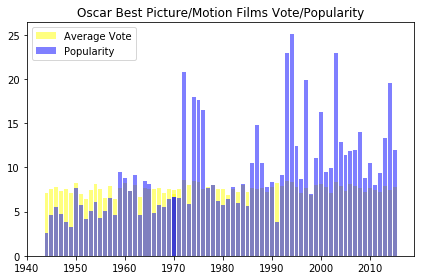

In [46]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


plt.figure(figsize=(20,200))
fig, ax = plt.subplots()
bar_width =0.8 
p1 = plt.bar(best_pictures_df['Year'],best_pictures_df['vote_average'],bar_width,color = 'yellow',alpha=0.5)

p2 = plt.bar(best_pictures_df['Year'],best_pictures_df['popularity'],bar_width,color = 'blue',alpha=0.5)



plt.title('Oscar Best Picture/Motion Films Vote/Popularity')
plt.legend((p1[0],p2[0]),('Average Vote','Popularity'))

plt.tight_layout()
plt.show()

## Oscar Best Picture Feature Enginerring

### - Build Training Data


In [47]:


new_col = ['id','title','budget','revenue','vote_average','runtime','vote_count','popularity','release_month','keywords','genres']


best_pic_label_df = best_pictures_df[new_col]


In [48]:
best_pic_label_df.release_month = best_pic_label_df.release_month.astype(int)

best_pic_label_df['keywords'] = best_pic_label_df['keywords'].apply(get_names)
best_pic_label_df['genres'] = best_pic_label_df['genres'].apply(get_names)

best_pic_label_df.head()

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,release_month,keywords,genres
1488,17661,Going My Way,0,16300000,7.1,130,51,2.555,5,priest,Drama|Comedy|Music
1646,28580,The Lost Weekend,1250000,11000000,7.6,101,185,4.578,11,desperation|paranoia|weekend|bartender|brother...,Drama
1762,887,The Best Years of Our Lives,2100000,23650000,7.8,172,207,5.491,12,usa|post traumatic stress disorder|war vetera...,Drama|History|Romance
1869,33667,Gentleman's Agreement,2000000,7800000,7.3,118,72,4.676,11,based on novel or book|magazine|anti semitism|...,Drama|Romance
1978,23383,Hamlet,750000,0,7.6,155,76,3.819,3,shakespeare|father murder|based on play or mus...,Drama


In [49]:
ind = 0

for i in range(len(tmdb_id_list)):
    ind = tmdb_movie_info_df.loc[tmdb_movie_info_df['id']==tmdb_id_list[i]].index.values.astype(int)
    if np.isnan(ind) == False:
        tmdb_movie_info_df = tmdb_movie_info_df.drop(ind, axis =0)
    

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


In [50]:
tmdb_movie_info_df.count()

id               4740
title            4740
budget           4740
revenue          4740
vote_average     4740
runtime          4740
vote_count       4740
popularity       4740
keywords         4740
genres           4740
release_month    4740
dtype: int64

In [51]:
tmdb_movie_info_df['won'] =0

In [52]:
tmdb_movie_info_df.head()

,id,title,budget,revenue,vote_average,runtime,vote_count,popularity,keywords,genres,release_month,won
0,19995,Avatar,237000000,2787965087,7.2,162.0,11800,150.437577,culture clash|future|space war|space colony|so...,Action|Adventure|Fantasy|Science Fiction,12,0
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,6.9,169.0,4500,139.082615,ocean|drug abuse|exotic island|east india trad...,Adventure|Fantasy|Action,5,0
2,206647,Spectre,245000000,880674609,6.3,148.0,4466,107.376788,spy|based on novel|secret agent|sequel|mi6|bri...,Action|Adventure|Crime,10,0
3,49026,The Dark Knight Rises,250000000,1084939099,7.6,165.0,9106,112.312950,dc comics|crime fighter|terrorist|secret ident...,Action|Crime|Drama|Thriller,7,0
4,49529,John Carter,260000000,284139100,6.1,132.0,2124,43.926995,based on novel|mars|medallion|space travel|pri...,Action|Adventure|Science Fiction,3,0


In [53]:
best_pic_label_df['won'] = 1




/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Genre Features - Winning Weight

In [54]:

winning_genre_counts['weight'] = winning_genre_counts['counts']/winning_genre_counts['counts'].sum()


In [55]:
winning_genre_counts

,genres,counts,weight
0,Drama,65,0.359116
1,Romance,22,0.121547
2,Comedy,17,0.093923
3,History,17,0.093923
4,War,11,0.060773
5,Crime,11,0.060773
6,Thriller,9,0.049724
7,Music,8,0.044199
8,Adventure,7,0.038674
9,Action,6,0.033149


In [56]:
gname = list(winning_genre_counts['genres'])
gweight = list(winning_genre_counts['weight'])             



In [57]:
gname

['Drama',
 'Romance',
 'Comedy',
 'History',
 'War',
 'Crime',
 'Thriller',
 'Music',
 'Adventure',
 'Action',
 'Family',
 'Fantasy',
 'Western',
 'Mystery']

In [58]:
genre_weight_dict = dict(zip(gname,gweight))
genre_weight_dict

{'Drama': 0.35911602209944754,
 'Romance': 0.12154696132596685,
 'Comedy': 0.09392265193370165,
 'History': 0.09392265193370165,
 'War': 0.06077348066298342,
 'Crime': 0.06077348066298342,
 'Thriller': 0.049723756906077346,
 'Music': 0.04419889502762431,
 'Adventure': 0.03867403314917127,
 'Action': 0.03314917127071823,
 'Family': 0.016574585635359115,
 'Fantasy': 0.011049723756906077,
 'Western': 0.011049723756906077,
 'Mystery': 0.0055248618784530384}

In [59]:
mean_weight = sum(gweight)/len(gweight)
genre_weight_dict.update({'other':mean_weight})

In [60]:
genre_weight_dict

{'Drama': 0.35911602209944754,
 'Romance': 0.12154696132596685,
 'Comedy': 0.09392265193370165,
 'History': 0.09392265193370165,
 'War': 0.06077348066298342,
 'Crime': 0.06077348066298342,
 'Thriller': 0.049723756906077346,
 'Music': 0.04419889502762431,
 'Adventure': 0.03867403314917127,
 'Action': 0.03314917127071823,
 'Family': 0.016574585635359115,
 'Fantasy': 0.011049723756906077,
 'Western': 0.011049723756906077,
 'Mystery': 0.0055248618784530384,
 'other': 0.07142857142857141}

In [61]:
w_genre_list = genre_weight_dict.keys()
w_genre_list

dict_keys(['Drama', 'Romance', 'Comedy', 'History', 'War', 'Crime', 'Thriller', 'Music', 'Adventure', 'Action', 'Family', 'Fantasy', 'Western', 'Mystery', 'other'])

In [62]:
full_movie_df = tmdb_movie_info_df.append(best_pic_label_df)
full_movie_df['won'].value_counts()

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


0    4740
1      73
Name: won, dtype: int64

In [63]:
test = list(full_movie_df['genres'])

In [64]:


weight=0
weight_list = []

for i in range(len(test)):
    onefilm = test[i].split('|')
    for j in range(len(onefilm)):
        if onefilm[j] in w_genre_list:
            weight  += genre_weight_dict[onefilm[j]]
        else:
             weight  += genre_weight_dict['other']
        
    weight_list.append(weight)
    weight = 0
    
len(weight_list)

4813

In [65]:
full_movie_df['genre_weight'] = weight_list

In [66]:
full_movie_df['profit'] = full_movie_df['revenue'] - full_movie_df['budget']

In [67]:
full_movie_df.head()


,budget,genres,id,keywords,popularity,release_month,revenue,runtime,title,vote_average,vote_count,won,genre_weight,profit
0,237000000,Action|Adventure|Fantasy|Science Fiction,19995,culture clash|future|space war|space colony|so...,150.437577,12,2787965087,162.0,Avatar,7.2,11800,0,0.154301,2550965087
1,300000000,Adventure|Fantasy|Action,285,ocean|drug abuse|exotic island|east india trad...,139.082615,5,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,0,0.082873,661000000
2,245000000,Action|Adventure|Crime,206647,spy|based on novel|secret agent|sequel|mi6|bri...,107.376788,10,880674609,148.0,Spectre,6.3,4466,0,0.132597,635674609
3,250000000,Action|Crime|Drama|Thriller,49026,dc comics|crime fighter|terrorist|secret ident...,112.312950,7,1084939099,165.0,The Dark Knight Rises,7.6,9106,0,0.502762,834939099
4,260000000,Action|Adventure|Science Fiction,49529,based on novel|mars|medallion|space travel|pri...,43.926995,3,284139100,132.0,John Carter,6.1,2124,0,0.143252,24139100


In [68]:
full_movie_df.to_csv('./DataSources/tmdb_training_data.csv')




# Oscar Best Picture Prediction Model

## Feature Dataset

In [69]:
numberic_features = ['budget','popularity','release_month','revenue','runtime','vote_average','vote_count','genre_weight','profit']
target = ['won']
all_set = numberic_features + target
all_set

['budget',
 'popularity',
 'release_month',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'genre_weight',
 'profit',
 'won']

In [70]:
num_feature_df = full_movie_df[all_set]

num_feature_df = num_feature_df.dropna()

In [71]:
#For simple log reg

simple_logit_df = num_feature_df

simple_logit_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,won
0,237000000,150.437577,12,2787965087,162.0,7.2,11800,0.154301,2550965087,0
1,300000000,139.082615,5,961000000,169.0,6.9,4500,0.082873,661000000,0
2,245000000,107.376788,10,880674609,148.0,6.3,4466,0.132597,635674609,0
3,250000000,112.312950,7,1084939099,165.0,7.6,9106,0.502762,834939099,0
4,260000000,43.926995,3,284139100,132.0,6.1,2124,0.143252,24139100,0


In [72]:
# Training Set

X = simple_logit_df.drop(columns=['won']).values
y = simple_logit_df['won'].values

#Scaled X
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

estimator = LogisticRegression(solver='sag',max_iter=20000) 
selector = RFE(estimator, 10, step=1)
selector.fit(X_scaled,y)
selector.ranking_

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([1, 1, 1, 1, 1, 1, 1, 1, 1])

In [73]:
len(simple_logit_df)

4813

In [74]:
#set features
X = simple_logit_df.drop(columns=['won']).values
#set label
y = simple_logit_df['won'].values

estimator = LogisticRegression(solver='sag',max_iter=20000) 
estimator.fit(X_scaled,y)
coeffs=estimator.coef_[0]

In [75]:
coeffs_list=(selector.estimator_.coef_[0])
print ('coefficients',selector.estimator_.coef_)

coefficients [[-1.47777235 -4.00805008  0.41195646  0.12935673  0.44172177  1.82113704
   1.55760413  0.69422852  0.59765985]]


In [76]:
features = simple_logit_df.drop(columns=['won']).columns.tolist()
feature_ranking = list(selector.ranking_)
ranking_df = zip(feature_ranking,features)
parameters=[]
for rank,parameter in ranking_df:
    if rank == 1:
        parameters.append(parameter)

In [77]:

Features_co_list=pd.DataFrame({"Feature": parameters,
                    "Coefficient": coeffs_list})
Features_co_list.sort_values('Coefficient', ascending=False)

,Feature,Coefficient
5,vote_average,1.821137
6,vote_count,1.557604
7,genre_weight,0.694229
8,profit,0.597660
4,runtime,0.441722
2,release_month,0.411956
3,revenue,0.129357
0,budget,-1.477772
1,popularity,-4.008050


## Model 1: Logistic Regression

In [78]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.40,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,y_train)


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
model = logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1891,    3],
       [  23,    9]])

Text(0.5, 257.44, 'Predicted label')

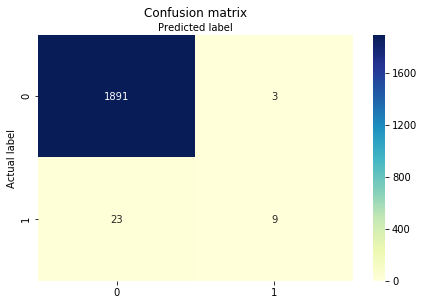

In [81]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [82]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9865005192107996
Precision: 0.75
Recall: 0.28125


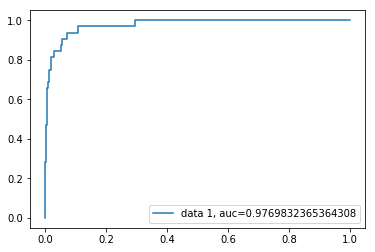

In [83]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 2019 Oscar Best Picture Movie Prediction

## Two Contentant Lists:  2019 TMDB Top 20 list  and 2019 OMDB Top list


In [92]:
#test_2019_df = pd.read_csv('./DataSources/test2019_tmdb.csv')
test_2019_df = pd.read_csv('./DataSources/test2017_tmdb.csv')
test_2019_df.head()
test_2019_omdb_df = pd.read_csv('./DataSources/test2019_omdb.csv')
test_2019_df.head()

,Unnamed: 0,id,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit
0,0,398818,4000000,16.849,9,41063475,132,8.3,3722,0.489270,37063475
1,1,399404,30000000,13.953,11,147568410,125,7.3,2162,0.433476,117568410
2,2,374720,100000000,21.633,7,525573161,107,7.4,7686,0.576180,425573161
3,3,497223,0,3.564,4,0,105,6.5,5,0.464592,0
4,4,391713,10000000,17.112,9,76858273,94,7.3,2958,0.447425,66858273


In [85]:
x_pre_test = test_2019_df[numberic_features]
#x_pre_test = test_2019_omdb_df[numberic_features]

In [86]:

x_pre = x_pre_test.values
X_pre_scaled = preprocessing.scale(x_pre)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [87]:
y_pred=logreg.predict(X_pre_scaled)

In [88]:
y_pro = model.predict_proba(X_pre_scaled)

In [89]:
for i in range(len(y_pred)):
    if y_pred[i] ==1: 
        index = i

In [94]:
pro_ranking = []
for i in range(len(y_pro)):
    pro_ranking.append(y_pro[i][1])

In [95]:
#test_2019_omdb_df['pred_pro'] = pro_ranking
#test_2019_omdb_df = test_2019_omdb_df.sort_values(by=['pred_pro'],ascending=False)
#test_2019_omdb_df = test_2019_omdb_df.reset_index()

test_2019_df['pred_pro'] = pro_ranking
test_2019_df = test_2019_df.sort_values(by=['pred_pro'],ascending=False)
test_2019_df = test_2019_df.reset_index()

In [96]:
print('Oscar Best Picture Movie 2019 :Probability Ranking:\n')

title = []
prob = []

for i in range(20):
    id = int(test_2019_df.ix[i]['id'])
    detail_query_link = base_url1 + str(id) + '?' + api_key
    response = requests.get(detail_query_link).json()
    print(response['original_title'],test_2019_df.ix[i]['pred_pro'])
    title.append(response['original_title'])
    prob.append(test_2019_df.ix[i]['pred_pro'])

Oscar Best Picture Movie 2019 :Probability Ranking:

Call Me by Your Name 0.028872538873837335


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.p

Three Billboards Outside Ebbing, Missouri 0.017055890299277617
Phantom Thread 0.006135499569117307
STEIG. NICHT. AUS! 0.002216446166506906
Darkest Hour 0.0010940106406135018
The Post 0.0009276592402744239
The Shape of Water 0.0005969776197707689
Dunkirk 0.0003673451992959652
Lady Bird 0.00017693002439332764


KeyError: 9

In [97]:
winning_prediction = pd.DataFrame({'Title':title,'Probability Ranking':prob})

In [98]:
winning_prediction

,Title,Probability Ranking
0,Call Me by Your Name,0.028873
1,"Three Billboards Outside Ebbing, Missouri",0.017056
2,Phantom Thread,0.006135
3,STEIG. NICHT. AUS!,0.002216
4,Darkest Hour,0.001094
5,The Post,0.000928
6,The Shape of Water,0.000597
7,Dunkirk,0.000367
8,Lady Bird,0.000177


## Model 2:  XGBoost

In [99]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# load data
XGB_df = num_feature_df

# split data into X and y
Xg = XGB_df.drop(columns=['won']).as_matrix()
Yg = XGB_df['won'].as_matrix()
# split data into train and test sets
seed = 7
test_size = 0.33
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, Yg, test_size=test_size, random_state=seed)


# fit model on training data
model_xgb = XGBClassifier()



eval_set = [(Xg_test, yg_test)]
model_xgb.fit(Xg_train, yg_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=True)
model_xgb.fit(Xg_train, yg_train)

# make predictions for test data
yg_pred = model_xgb.predict(Xg_test)
predictions = [round(value) for value in yg_pred]
# evaluate predictions
accuracy = accuracy_score(yg_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.00944
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.00944
[2]	validation_0-error:0.00944
[3]	validation_0-error:0.00944
[4]	validation_0-error:0.00944
[5]	validation_0-error:0.00944
[6]	validation_0-error:0.00944
[7]	validation_0-error:0.010069
[8]	validation_0-error:0.010069
[9]	validation_0-error:0.010069
[10]	validation_0-error:0.00944
Stopping. Best iteration:
[0]	validation_0-error:0.00944

Accuracy: 99.06%


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [100]:
print(model_xgb.feature_importances_)

[0.05189621 0.23752496 0.04590818 0.01596806 0.13373253 0.18762475
 0.12774451 0.07984032 0.11976048]


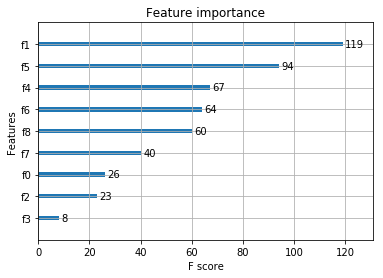

In [101]:
plot_importance(model_xgb)
plt.show()

## XGBoost Prediction

In [102]:
x_pre = x_pre_test.as_matrix()

y_pro_xgb = model_xgb.predict(x_pre)


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [104]:
for i in range(len(y_pro_xgb)):
    if (y_pro_xgb[i] == 1):
        best_picture_tmdb_id = int(test_2019_df.ix[i].id)
        detail_query_link = base_url1 + str(best_picture_tmdb_id) + '?' + api_key
        response = requests.get(detail_query_link).json()
        pprint('best picture:')
        pprint(response['title'])

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


'best picture:'
'Call Me by Your Name'
'best picture:'
'Lady Bird'


# Ensemble Training

In [105]:
num_feature_df.columns

Index(['budget', 'popularity', 'release_month', 'revenue', 'runtime',
       'vote_average', 'vote_count', 'genre_weight', 'profit', 'won'],
      dtype='object')

In [106]:

train_db_df = num_feature_df
train_db_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,won
0,237000000,150.437577,12,2787965087,162.0,7.2,11800,0.154301,2550965087,0
1,300000000,139.082615,5,961000000,169.0,6.9,4500,0.082873,661000000,0
2,245000000,107.376788,10,880674609,148.0,6.3,4466,0.132597,635674609,0
3,250000000,112.312950,7,1084939099,165.0,7.6,9106,0.502762,834939099,0
4,260000000,43.926995,3,284139100,132.0,6.1,2124,0.143252,24139100,0


In [107]:
train_db_df.fillna(0) 

from sklearn.utils import shuffle
train_db_df = shuffle(train_db_df)

In [108]:
train_db_df= train_db_df.fillna(0) 
train_db_df.head()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,won
673,63000000,40.137264,7,296655431,94.0,5.9,979,0.226125,233655431,0
2206,0,17.988170,9,0,102.0,6.4,286,0.226519,0,0
4526,0,0.082978,1,0,101.0,4.8,4,0.171271,0,0
492,8000000,0.719996,10,0,89.0,5.3,9,0.165351,-8000000,0
4408,0,1.255771,1,0,99.0,5.4,8,0.502762,0,0


In [109]:
ix_ran = train_db_df.index.values
np.random.shuffle(ix_ran)

df_len = len(train_db_df)
train_len = int(df_len * 0.8)  


ix_train = ix_ran[:train_len]
ix_valid = ix_ran[train_len:]

df_train = train_db_df.ix[ix_train]
df_valid = train_db_df.ix[ix_valid]

print(len(ix_train))
print(len(ix_valid))

3850
963


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [110]:
df_train.head()
len(df_train[df_train['won'] == 1])
len(df_valid[df_valid['won'] == 1])

22

In [111]:
df_train = df_train.fillna(0)
df_valid = df_valid.fillna(0)
df_train.tail()

,budget,popularity,release_month,revenue,runtime,vote_average,vote_count,genre_weight,profit,won
3783,28,9.670031,12,14,93.0,5.9,173,0.237569,-14,0
348,15000000,3.043589,10,21000000,95.0,6.1,52,0.359116,6000000,0
2392,0,5.902590,6,0,99.0,6.5,25,0.502762,0,0
778,2053648,2.778633,10,500000,102.0,7.8,17,0.071429,-1553648,0
456,17000000,19.311572,1,9500000,122.0,7.0,331,0.502762,-7500000,0


In [112]:
train_col = ['budget', 'popularity', 'release_month', 'revenue', 'runtime','vote_average', 'vote_count', 'genre_weight', 'profit']

In [113]:
from sklearn import preprocessing
X= df_train.drop(columns=['won']).values
X = X[~np.isnan(X).any(axis=1)]
X_scaled = preprocessing.scale(X)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [114]:
X= df_train[train_col].values
Y = df_train['won'].values
clf =  LogisticRegression(C=1e5, class_weight={0:1, 1:4000}, n_jobs=3)
clf.fit(X,Y)
y_p=clf.predict_proba(X)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [115]:
y_p

array([[2.12702153e-07, 9.99999787e-01],
       [4.99999999e-01, 5.00000001e-01],
       [5.00000000e-01, 5.00000000e-01],
       ...,
       [5.00000000e-01, 5.00000000e-01],
       [5.15762053e-01, 4.84237947e-01],
       [5.47960628e-01, 4.52039372e-01]])

In [116]:
params_0 = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:4000}, 'n_jobs':5}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight={0:1, 1:4000}, n_jobs=3),
    
    GaussianNB(),

    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [117]:
X_train = df_train[train_col].values

y_train = df_train['won'].values
    
X_train = scaler.fit_transform(X_train)

X_valid = df_valid[train_col].values
y_valid = df_valid['won'].values
X_valid_x= scaler.transform(X_valid)

In [118]:
prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train,y_train)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_x)
    prob_pos  = clf.predict_proba(X_valid_x)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid, y_pred)
    clf_score = brier_score_loss(y_valid, prob_pos, pos_label=y_valid.max())
    print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid, y_pred))
    print("\tRecall: %1.5f" % recall_score(y_valid, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )


LogisticRegression:
	Brier: 0.14164
	Precision: 0.11702
	Recall: 1.00000
	F1: 0.20952
	auc: 0.98687
	Accuracy: 0.82957

GaussianNB:
	Brier: 0.01160
	Precision: 0.70000
	Recall: 0.63636
	F1: 0.66667
	auc: 0.98539
	Accuracy: 0.98563

RandomForestClassifier:


/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/my_macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


	Brier: 0.02458
	Precision: 0.33962
	Recall: 0.81818
	F1: 0.48000
	auc: 0.97851
	Accuracy: 0.95996

ExtraTreesClassifier:
	Brier: 0.13945
	Precision: 0.09677
	Recall: 0.95455
	F1: 0.17573
	auc: 0.95197
	Accuracy: 0.79774

GradientBoostingClassifier:
	Brier: 0.00886
	Precision: 0.94118
	Recall: 0.72727
	F1: 0.82051
	auc: 0.86385
	Accuracy: 0.99281



In [119]:
feature_importance = clfs_fited[2].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

In [120]:
feature_importance[sorted_idx]

array([  1.6425943 ,   2.88942518,   4.65768352,   8.18743323,
        15.11740152,  28.23474567,  29.99514985,  56.08561377,
       100.        ])

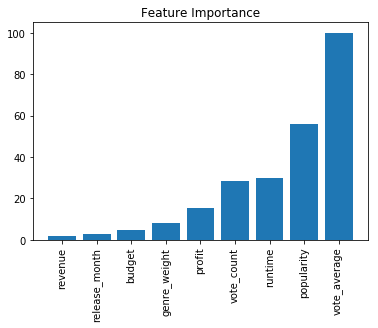

In [121]:
features = [train_col[ix] for ix in sorted_idx]
bardata = {"name":features[::-1], "importance percent":feature_importance[sorted_idx][::-1]}
# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), feature_importance[sorted_idx])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), features, rotation=90)

# Show plot
plt.show()

In [128]:
x_pre = x_pre_test.as_matrix()
y_p_en=clfs[0].predict_proba(x_pre)

/Users/my_macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [125]:
y_p_en

array([[0.94001557, 0.05998443],
       [0.93801607, 0.06198393],
       [0.93801557, 0.06198443],
       [0.81444502, 0.18555498],
       [0.94001557, 0.05998443],
       [0.93401807, 0.06598193],
       [0.93601757, 0.06398243],
       [0.93801557, 0.06198443],
       [0.94001557, 0.05998443]])

# 2018 Movie Analysis 

## 1. The highest revenues Movies in 2018 

In [129]:
#2018 the highest revenues Movies

discovery_link = 'https://api.themoviedb.org/3/discover/movie?'
query_release_year = '&primary_release_year='
rev_sort_by = '&sort_by=revenue.desc'
rev_2018_query_link = discovery_link + api_key + query_release_year + '2018' + rev_sort_by

high_rev_2018 = requests.get(rev_2018_query_link).json()






In [130]:
high_rev_2018_result = high_rev_2018['results']


In [131]:
movie_rev_list = []
movie_title_list = []

for movie in high_rev_2018_result:
    tmdb_id = str(movie['id']) + '?'
    detail_query_link = base_url1 + tmdb_id + api_key + language
    response = requests.get(detail_query_link).json()
    movie_rev_list.append(response['revenue'])
    movie_title_list.append(response['title'])



In [132]:
columns = ['Name','Revenue']
rev_ranking2018_df = pd.DataFrame(columns=columns)

rev_ranking2018_df['Name'] =pd.Series(movie_title_list).values

rev_ranking2018_df['Revenue'] =pd.Series(movie_rev_list).values



In [133]:
rev_ranking2018_df= rev_ranking2018_df.set_index('Name')

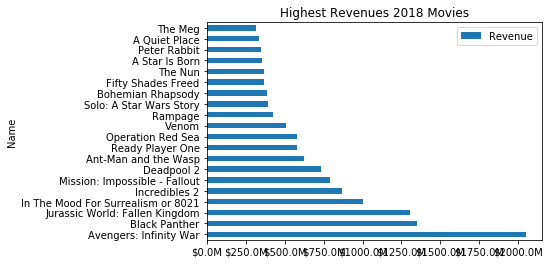

In [134]:
fig, ax = plt.subplots()

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
formatter = FuncFormatter(millions)
ax.xaxis.set_major_formatter(formatter)


rev_ranking2018_df.plot(kind = 'barh',ax=ax, title = 'Highest Revenues 2018 Movies')


## 2. 2018 Movie Popularity Ranking 

In [135]:
pop_sort_by = '&sort_by=popularity.desc'
pop_2018_query_link = discovery_link + api_key + query_release_year + '2018' + pop_sort_by

high_pop_2018 = requests.get(pop_2018_query_link).json()



In [136]:
high_pop_2018

{'page': 1,
 'total_results': 12388,
 'total_pages': 620,
 'results': [{'vote_count': 2441,
   'id': 335983,
   'video': False,
   'vote_average': 6.5,
   'title': 'Venom',
   'popularity': 368.719,
   'poster_path': '/2uNW4WbgBXL25BAbXGLnLqX71Sw.jpg',
   'original_language': 'en',
   'original_title': 'Venom',
   'genre_ids': [878],
   'backdrop_path': '/VuukZLgaCrho2Ar8Scl9HtV3yD.jpg',
   'adult': False,
   'overview': 'Eddie Brock is a reporter, investigating people who want to go unnoticed. But after he makes a terrible discovery at the Life Foundation, he begins to transform into ‘Venom’.  The Foundation has discovered creatures called symbiotes, and believes they’re the key to the next step in human evolution. Unwittingly bonded with one, Eddie discovers he has incredible new abilities - and a voice in his head that’s telling him to embrace the darkness.  One of Marvel’s most celebrated anti-heroes comes to the big screen in ‘Venom’, starring Tom Hardy, Michelle Williams and Riz 

In [137]:
high_pop_2018_result = high_pop_2018['results']



In [138]:
high_pop_2018_result

[{'vote_count': 2441,
  'id': 335983,
  'video': False,
  'vote_average': 6.5,
  'title': 'Venom',
  'popularity': 368.719,
  'poster_path': '/2uNW4WbgBXL25BAbXGLnLqX71Sw.jpg',
  'original_language': 'en',
  'original_title': 'Venom',
  'genre_ids': [878],
  'backdrop_path': '/VuukZLgaCrho2Ar8Scl9HtV3yD.jpg',
  'adult': False,
  'overview': 'Eddie Brock is a reporter, investigating people who want to go unnoticed. But after he makes a terrible discovery at the Life Foundation, he begins to transform into ‘Venom’.  The Foundation has discovered creatures called symbiotes, and believes they’re the key to the next step in human evolution. Unwittingly bonded with one, Eddie discovers he has incredible new abilities - and a voice in his head that’s telling him to embrace the darkness.  One of Marvel’s most celebrated anti-heroes comes to the big screen in ‘Venom’, starring Tom Hardy, Michelle Williams and Riz Ahmed.',
  'release_date': '2018-10-03'},
 {'vote_count': 1473,
  'id': 338952,
  

In [139]:
high_pop_2018_result[1]['popularity']

315.827

In [140]:
movie_pop_list = []
movie_title_list = []

for i in range(len(high_pop_2018_result)):
    movie_pop_list.append(high_pop_2018_result[i]['popularity'])
    movie_title_list.append(high_pop_2018_result[i]['title'])



In [141]:
columns = ['Name','Popularity']
rate_ranking2018_df = pd.DataFrame(columns=columns)

rate_ranking2018_df['Name'] =pd.Series(movie_title_list).values

rate_ranking2018_df['Popularity'] =pd.Series(movie_pop_list).values

rate_ranking2018_df= rate_ranking2018_df.set_index('Name')

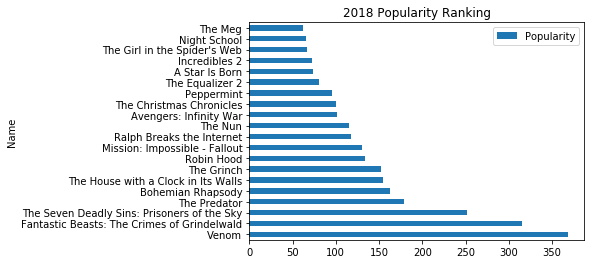

In [142]:
rate_ranking2018_df.plot(kind = 'barh',title ='2018 Popularity Ranking')



In [143]:
rate_ranking2018_df.reset_index()
rate_ranking2018_df.to_csv('./DataSources/rate2018_tmdb.csv')